In [1]:
import pandas as pd
import subprocess
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


To run DeepTP, we create a large fasta file from the test data

In [ ]:

input_data = pd.read_csv("./dataset/final_testing.csv")
input_data["id"] = list(range(0,len(input_data))) #add id column

print(len(input_data))
input_data.head(n=1)

26282


,Unnamed: 0,Sequence,output,ankh_large,id
0,0,MRAAYACDPMATRGRAVVEEESAHRSPFQRDRDRIIHSSAFRRLKH...,0,"[0.017813269048929214, -0.008698908612132072, ...",0


Write valid sequences to fasta, with valid letters being:

https://www.bioinformatics.org/sms/iupac.html 

In [3]:
count_excluded = 0
f= open("./inputs.fasta","w") #create a fasta file 
for i, row in input_data.iterrows():
    #get current sequence entry code, with the classification output
    true_class = row["output"]#real classification
    entry = row["id"]
    seq = row["Sequence"]
    
    #create a single query fasta
    if "X" in seq or "B" in seq or "U" in seq or "Z" in seq: #do not write sequences that have invalid
        count_excluded += 1
        continue
    else: 
        f.write(f">{entry}\n")
        f.write(f"{seq}\n")
f.close()

print("number of excluded/invalid sequences:", count_excluded)

number of excluded/invalid sequences: 185


Run the DeepTP script

In [4]:
subprocess.run([
    "python", "./DeepTP/DeepTP.py",
    "--seq", "./inputs.fasta",
    "--out", "outputs.csv"
])


Performing data processing ......

Performing protein prediction ......



Aborted!


KeyboardInterrupt: 

### evaluation: comparing results to actual data

In [5]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Loading in predicted data

In [6]:
predicted_data = pd.read_csv("outputs.csv")
print(len(predicted_data))
predicted_data.head(n=3)

24241


,SeqID,Probability of TP,Prediction of TP
0,0,3.545421e-04,0
1,1,2.162038e-07,0
2,2,9.920144e-01,1


Selecting matching rows in the test dataset based on the sequence id column

In [7]:
pred_rows = predicted_data["SeqID"].tolist()
comparison = input_data[input_data["id"].isin(pred_rows)]
print(len(comparison))


24241


Comparison results

In [8]:
Y_test = predicted_data["Prediction of TP"]
test_classified = comparison["output"]
# Calculate evaluation metrics using this final cutoff
report = classification_report(Y_test, test_classified)
print(f'Test Classification Report:\n{report}')

print('Test Accuracy:,', accuracy_score(Y_test, test_classified))
print('Test Precision:,', metrics.precision_score(Y_test, test_classified)) #ability to classify negatives  
print('Test recall:,', metrics.recall_score(Y_test, test_classified)) #ability to classify positives  
print('Test f1:,', metrics.f1_score(Y_test, test_classified)) #ability to classify positives  
print("Test roc_auc_score:", metrics.roc_auc_score(Y_test, test_classified))
print("Test matthews_corrcoef(MCC):", metrics.matthews_corrcoef(Y_test, test_classified))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     20215
           1       0.46      0.76      0.57      4026

    accuracy                           0.81     24241
   macro avg       0.70      0.79      0.72     24241
weighted avg       0.86      0.81      0.83     24241

Test Accuracy:, 0.8110226475805453
Test Precision:, 0.4581889407864999


Test recall:, 0.7553402881271734
Test f1:, 0.5703835693519647
Test roc_auc_score: 0.788726290489508
Test matthews_corrcoef(MCC): 0.48194612876889364


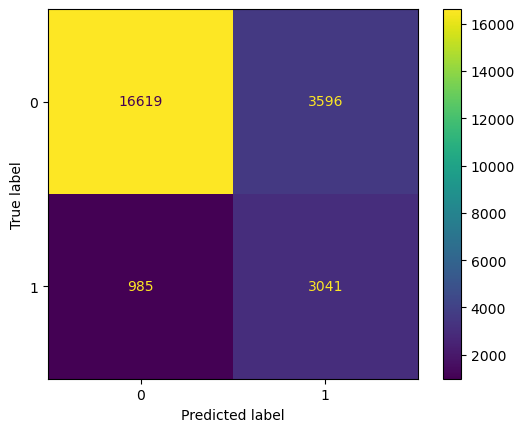

In [9]:
confusion_matrix = metrics.confusion_matrix(Y_test, test_classified)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()